In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import TensorBoard
from skimage.metrics import structural_similarity as compare_ssim
import numpy as np
import os
import glob
import time
import cv2
from tqdm import tqdm
import warnings;
warnings.filterwarnings('ignore')

In [2]:
if tf.test.gpu_device_name():
    print('GPU found')
    gpu_devices = tf.config.list_physical_devices('GPU')
    if gpu_devices:
        details = tf.config.experimental.get_device_details(gpu_devices[0])
        print(details.get('device_name'))
else:
    print("No GPU found")

GPU found
NVIDIA GeForce GTX 1650


In [3]:
#############################################################################
seed = 42
np.random.seed = seed
tf.random.set_seed(seed)
#############################################################################
IMG_HEIGHT=128
IMG_WIDTH=128
IMG_CHANNELS=1

In [4]:
x_train_data = glob.glob('E:\\IIIT_Allahabad\\mbi2021006\\new_create\\SIMULATED_GRAY\\combine\\RECON\\*.jpg')
x_train_data.sort(key=len)
x_train = []
for i in tqdm(x_train_data):
    img = load_img(i, target_size=(128,128))
    img = img_to_array(img)
    img = np.mean(img,axis=2)
    img = img/255
    x_train.append(img)
x_train = np.array(x_train)

100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 1372.60it/s]


In [5]:
y_train_data = glob.glob('E:\\IIIT_Allahabad\\mbi2021006\\new_create\\SIMULATED_GRAY\\combine\\GT\\*.jpg')
y_train_data.sort(key=len)
y_train = []
for i in tqdm(y_train_data):
    img1 = load_img(i, target_size=(128,128))
    img1 = img_to_array(img1)
    img1 = np.mean(img1,axis=2)
    img1 = img1/255
    y_train.append(img1)
y_train = np.array(y_train)

100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 1625.97it/s]


In [6]:
############################################################################################################################
def Convolution(input, filters, kernel_size, strides, activation, kernel_initializer, padding):
    out = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides= strides, 
                                 activation=activation, kernel_initializer=kernel_initializer, padding=padding)(input)
    #out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
    #                                    beta_initializer='zeros', gamma_initializer='ones',
    #                                    moving_mean_initializer='zeros',
    #                                    moving_variance_initializer='ones', beta_regularizer=None,
    #                                    gamma_regularizer=None,
    #                                    beta_constraint=None, gamma_constraint=None)(out)
    return out
############################################################################################################################
############################################################################################################################
def Transpose_Convolution(input, filters, kernel_size, strides, activation, kernel_initializer, padding):
    out = tf.keras.layers.Conv2DTranspose(filters, kernel_size=kernel_size, strides= strides, 
                                          activation=activation, kernel_initializer=kernel_initializer, padding=padding)(input)
    #out = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
    #                                    beta_initializer='zeros', gamma_initializer='ones',
    #                                    moving_mean_initializer='zeros',
    #                                    moving_variance_initializer='ones', beta_regularizer=None,
    #                                    gamma_regularizer=None,
    #                                    beta_constraint=None, gamma_constraint=None)(out)
    return out

############################################################################################################################
############################################################################################################################
def DownBlock(input, filters, kernel_size, padding, activation, kernel_initializer):
    out = FD_Block(input, f_in=filters // 2, f_out=filters, k=filters // 8, kernel_size=3, padding='same',
                   activation=activation, kernel_initializer='glorot_normal')
    shortcut = out
    out = DownSample(out, filters, kernel_size, strides=2, padding=padding,
                     activation=activation, kernel_initializer=kernel_initializer)
    return [out, shortcut]
############################################################################################################################
############################################################################################################################
def BrigdeBlock(input, filters, kernel_size, padding, activation, kernel_initializer):
    out = FD_Block(input, f_in=filters // 2, f_out=filters, k=filters // 8, kernel_size=3, padding='same',
                   activation=activation, kernel_initializer='glorot_normal')
    out = UpSample(out, filters, kernel_size, strides=2, padding=padding,
                   activation=activation, kernel_initializer=kernel_initializer)
    return out
############################################################################################################################
############################################################################################################################
def UpBlock(input, filters, kernel_size, padding, activation, kernel_initializer):
    out = Convolution(input, filters= filters//2, kernel_size=1, strides=1, activation=activation,
                           kernel_initializer=kernel_initializer, padding=padding)
    out = FD_Block(out, f_in=filters // 2, f_out=filters, k=filters // 8, kernel_size=3, padding='same',
                   activation=activation, kernel_initializer='glorot_normal')
    out = UpSample(out, filters, kernel_size, strides=2, padding=padding,
                     activation=activation, kernel_initializer=kernel_initializer)
    return out
############################################################################################################################
############################################################################################################################
def FD_Block(input, f_in, f_out, k, kernel_size, padding, activation, kernel_initializer):
    out = input
    for i in range(f_in, f_out, k):
        shortcut = out
        out = Convolution(out, filters=f_in, kernel_size=1, strides=1, padding=padding,
                               activation=activation, kernel_initializer=kernel_initializer)
        out = Convolution(out, filters=k, kernel_size=kernel_size, strides=1, padding=padding,
                               activation=activation, kernel_initializer=kernel_initializer)
        out = tf.keras.layers.Dropout(0.2, seed=seed)(out)
        out = tf.keras.layers.concatenate([out, shortcut])
    return out
############################################################################################################################
############################################################################################################################
def DownSample(input, filters, kernel_size, strides, padding, activation, kernel_initializer):
    out = Convolution(input, filters, kernel_size=1, strides=1, 
                      activation= activation, kernel_initializer= kernel_initializer, padding=padding)
    out = Convolution(out, filters, kernel_size=kernel_size, strides=strides, activation=activation,
                           kernel_initializer=kernel_initializer, padding=padding)
    return out
############################################################################################################################
############################################################################################################################
def UpSample(input, filters, kernel_size, strides, padding, activation, kernel_initializer):
    out = Convolution(input, filters, kernel_size=1, strides=1, padding=padding,
                           activation=activation, kernel_initializer=kernel_initializer)
    out = Transpose_Convolution(out, filters//2, kernel_size=kernel_size, strides=strides, activation=activation,
                           kernel_initializer=kernel_initializer, padding=padding)
    return out
############################################################################################################################


In [7]:
########################################################################################################################
'''Define parameters'''
########################################################################################################################
kernel_initializer = tf.keras.initializers.glorot_normal(seed=seed)
activation = 'relu'
filters = 16
padding = 'same'
kernel_size = 3
strides = 1

In [8]:
##############################################################################################
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = inputs
out = Convolution(s, filters, kernel_size=kernel_size, strides= strides, activation=activation, kernel_initializer=kernel_initializer, padding=padding)

[out, c1] = DownBlock(out, filters*2**1, kernel_size, padding, activation, kernel_initializer)
[out, c2] = DownBlock(out, filters*2**2, kernel_size, padding, activation, kernel_initializer)
[out, c3] = DownBlock(out, filters*2**3, kernel_size, padding, activation, kernel_initializer)
[out, c4] = DownBlock(out, filters*2**4, kernel_size, padding, activation, kernel_initializer)
[out, c5] = DownBlock(out, filters*2**5, kernel_size, padding, activation, kernel_initializer)

out = BrigdeBlock(out, filters*2**6, kernel_size, padding, activation, kernel_initializer)

out = tf.keras.layers.concatenate([out, c5])
out = UpBlock(out, filters*2**5, kernel_size, padding, activation, kernel_initializer)


out = tf.keras.layers.concatenate([out, c4])
out = UpBlock(out, filters*2**4, kernel_size, padding, activation, kernel_initializer)
out = tf.keras.layers.concatenate([out, c3])
out = UpBlock(out, filters*2**3, kernel_size, padding, activation, kernel_initializer)
out = tf.keras.layers.concatenate([out, c2])
out = UpBlock(out, filters*2**2, kernel_size, padding, activation, kernel_initializer)
out = tf.keras.layers.concatenate([out, c1])

out = Convolution(out, filters, kernel_size=1, strides=1, activation=activation, kernel_initializer=kernel_initializer, padding=padding)
out = FD_Block(out, f_in=filters, f_out=filters*2, k=filters // 4, kernel_size=3, padding=padding,
                   activation=activation, kernel_initializer=kernel_initializer)

out = tf.keras.layers.Conv2D(filters=1, kernel_size=1, strides=1, padding=padding, activation='linear', kernel_initializer=kernel_initializer)(out)
out = tf.keras.layers.Add()([out, s])
out = tf.keras.layers.ReLU()(out)
outputs = out
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
##################################################################################################################################


In [9]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
model.compile(optimizer=opt, loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()])
model.summary()
###############################################################################################################
FOLDER_NAME="UnetArchitecture_de_02_2glob/"
os.makedirs(FOLDER_NAME)
MODEL_NAME='tt_AP_02_2glob_FDDUnet.h5'
MODEL_NAME = FOLDER_NAME + MODEL_NAME
#################################################################################################################
epochs = 100
PATIENCE = 5
MONITOR = 'val_loss'
##################################################################################################################
callbacks = [tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, verbose=1, save_best_only=True), 
             tf.keras.callbacks.EarlyStopping(patience=PATIENCE, monitor=MONITOR)]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  272         ['conv2d[0][0]']                 
                                )                                                             

 conv2d_18 (Conv2D)             (None, 64, 64, 8)    2312        ['conv2d_17[0][0]']              
                                                                                                  
 dropout_7 (Dropout)            (None, 64, 64, 8)    0           ['conv2d_18[0][0]']              
                                                                                                  
 concatenate_7 (Concatenate)    (None, 64, 64, 64)   0           ['dropout_7[0][0]',              
                                                                  'concatenate_6[0][0]']          
                                                                                                  
 conv2d_19 (Conv2D)             (None, 64, 64, 64)   4160        ['concatenate_7[0][0]']          
                                                                                                  
 conv2d_20 (Conv2D)             (None, 32, 32, 64)   36928       ['conv2d_19[0][0]']              
          

                                                                                                  
 concatenate_15 (Concatenate)   (None, 16, 16, 256)  0           ['dropout_15[0][0]',             
                                                                  'concatenate_14[0][0]']         
                                                                                                  
 conv2d_39 (Conv2D)             (None, 16, 16, 256)  65792       ['concatenate_15[0][0]']         
                                                                                                  
 conv2d_40 (Conv2D)             (None, 8, 8, 256)    590080      ['conv2d_39[0][0]']              
                                                                                                  
 conv2d_41 (Conv2D)             (None, 8, 8, 256)    65792       ['conv2d_40[0][0]']              
                                                                                                  
 conv2d_42

                                                                                                  
 conv2d_59 (Conv2D)             (None, 4, 4, 1024)   1049600     ['concatenate_23[0][0]']         
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 8, 8, 512)   4719104     ['conv2d_59[0][0]']              
 ose)                                                                                             
                                                                                                  
 concatenate_24 (Concatenate)   (None, 8, 8, 1024)   0           ['conv2d_transpose[0][0]',       
                                                                  'concatenate_19[0][0]']         
                                                                                                  
 conv2d_60 (Conv2D)             (None, 8, 8, 256)    262400      ['concatenate_24[0][0]']         
          

                                                                                                  
 conv2d_77 (Conv2D)             (None, 16, 16, 128)  28800       ['concatenate_32[0][0]']         
                                                                                                  
 conv2d_78 (Conv2D)             (None, 16, 16, 32)   36896       ['conv2d_77[0][0]']              
                                                                                                  
 dropout_31 (Dropout)           (None, 16, 16, 32)   0           ['conv2d_78[0][0]']              
                                                                                                  
 concatenate_33 (Concatenate)   (None, 16, 16, 256)  0           ['dropout_31[0][0]',             
                                                                  'concatenate_32[0][0]']         
                                                                                                  
 conv2d_79

                                                                                                  
 conv2d_95 (Conv2D)             (None, 64, 64, 32)   1568        ['concatenate_41[0][0]']         
                                                                                                  
 conv2d_96 (Conv2D)             (None, 64, 64, 8)    2312        ['conv2d_95[0][0]']              
                                                                                                  
 dropout_38 (Dropout)           (None, 64, 64, 8)    0           ['conv2d_96[0][0]']              
                                                                                                  
 concatenate_42 (Concatenate)   (None, 64, 64, 56)   0           ['dropout_38[0][0]',             
                                                                  'concatenate_41[0][0]']         
                                                                                                  
 conv2d_97

In [10]:
##################################################################################################################
start = time.time()
history = model.fit(x_train,y_train, validation_split=0.1, batch_size=2, epochs=epochs, callbacks=callbacks)
end = time.time()
temp = end-start
hours = temp//3600
temp = temp - 3600*hours
minutes = temp//60
seconds = temp - 60*minutes
print("time taken to train the model : ")
print('%d:%d:%d' %(hours,minutes,seconds))

Epoch 1/100
270/270 [==============================] - ETA: 0s - loss: 0.1967 - mean_absolute_error: 0.1967 - mean_squared_error: 0.0852
Epoch 1: val_loss improved from inf to 0.13209, saving model to UnetArchitecture_de_02_2glob\tt_AP_02_2glob_FDDUnet.h5
270/270 [==============================] - 34s 85ms/step - loss: 0.1967 - mean_absolute_error: 0.1967 - mean_squared_error: 0.0852 - val_loss: 0.1321 - val_mean_absolute_error: 0.1321 - val_mean_squared_error: 0.0340
Epoch 2/100
270/270 [==============================] - ETA: 0s - loss: 0.0698 - mean_absolute_error: 0.0698 - mean_squared_error: 0.0242
Epoch 2: val_loss improved from 0.13209 to 0.07391, saving model to UnetArchitecture_de_02_2glob\tt_AP_02_2glob_FDDUnet.h5
270/270 [==============================] - 23s 85ms/step - loss: 0.0698 - mean_absolute_error: 0.0698 - mean_squared_error: 0.0242 - val_loss: 0.0739 - val_mean_absolute_error: 0.0739 - val_mean_squared_error: 0.0198
Epoch 3/100
270/270 [=============================

Epoch 19/100
270/270 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0078 - mean_squared_error: 1.5533e-04
Epoch 19: val_loss improved from 0.00846 to 0.00716, saving model to UnetArchitecture_de_02_2glob\tt_AP_02_2glob_FDDUnet.h5
270/270 [==============================] - 23s 85ms/step - loss: 0.0078 - mean_absolute_error: 0.0078 - mean_squared_error: 1.5533e-04 - val_loss: 0.0072 - val_mean_absolute_error: 0.0072 - val_mean_squared_error: 1.4037e-04
Epoch 20/100
270/270 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0065 - mean_squared_error: 1.2529e-04
Epoch 20: val_loss improved from 0.00716 to 0.00679, saving model to UnetArchitecture_de_02_2glob\tt_AP_02_2glob_FDDUnet.h5
270/270 [==============================] - 23s 86ms/step - loss: 0.0065 - mean_absolute_error: 0.0065 - mean_squared_error: 1.2529e-04 - val_loss: 0.0068 - val_mean_absolute_error: 0.0068 - val_mean_squared_error: 1.3275e-04
Epoch 21/100
270/2

In [11]:
x_test_data_s1 = glob.glob('E:\\IIIT_Allahabad\\mbi2021006\\new_create\\EXPERIMENT\\combine\\RECON\\*.jpg')
x_test_data_s1.sort(key=len)
x_test_s1 = []
for i in tqdm(x_test_data_s1):
    img3 = load_img(i, target_size=(128,128))
    img3 = img_to_array(img3)
    img3 = np.mean(img3,axis=2)
    img3 = img3/255
    x_test_s1.append(img3)
x_test_s1 = np.array(x_test_s1)

100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 999.38it/s]


In [12]:
y_test_data_s1 = glob.glob('E:\\IIIT_Allahabad\\mbi2021006\\new_create\\EXPERIMENT\\combine\\GT\\*.jpg')
y_test_data_s1.sort(key=len)
y_test_s1 = []
for i in tqdm(y_test_data_s1):
    img4 = load_img(i, target_size=(128,128))
    img4 = img_to_array(img4)
    img4 = np.mean(img4,axis=2)
    img4 = img4/255
    y_test_s1.append(img4)
y_test_s1 = np.array(y_test_s1)

100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 1427.58it/s]


In [13]:
################################################################################################################################
print(model.evaluate(x_test_s1, y_test_s1))
################################################################################################################################
preds_test_s1=model.predict(x_test_s1,verbose=1)
preds_test_s1 = preds_test_s1.reshape(-3,128,128)
##################################################################

1/1 [==============================] - 3s 3s/step - loss: 0.0314 - mean_absolute_error: 0.0314 - mean_squared_error: 0.0199
[0.031354259699583054, 0.031354259699583054, 0.01992470771074295]
1/1 [==============================] - 1s 1s/step


(-0.5, 127.5, 127.5, -0.5)

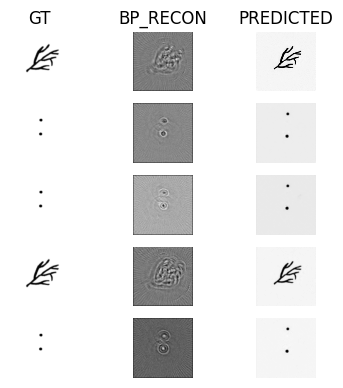

In [18]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(4.5,4.5))
rows=5
columns=3

fig.add_subplot(rows,columns,1)
plt.imshow(y_test_s1[0],cmap=plt.cm.gray)
plt.title("GT")
plt.axis('off')

fig.add_subplot(rows,columns,2)
plt.imshow(x_test_s1[0],cmap=plt.cm.gray)
plt.title("BP_RECON")
plt.axis('off')

fig.add_subplot(rows,columns,3)
plt.imshow(preds_test_s1[0],cmap='gray',interpolation="nearest")
plt.title("PREDICTED")
plt.axis('off')

fig.add_subplot(rows,columns,4)
plt.imshow(y_test_s1[11],cmap=plt.cm.gray)
plt.axis('off')

fig.add_subplot(rows,columns,5)
plt.imshow(x_test_s1[11],cmap=plt.cm.gray)
plt.axis('off')

fig.add_subplot(rows,columns,6)
plt.imshow(preds_test_s1[11],cmap=plt.cm.gray)
plt.axis('off')

fig.add_subplot(rows,columns,7)
plt.imshow(y_test_s1[15],cmap=plt.cm.gray)
plt.axis('off')

fig.add_subplot(rows,columns,8)
plt.imshow(x_test_s1[15],cmap=plt.cm.gray)
plt.axis('off')

fig.add_subplot(rows,columns,9)
plt.imshow(preds_test_s1[15],cmap=plt.cm.gray)
plt.axis('off')

fig.add_subplot(rows,columns,10)
plt.imshow(y_test_s1[20],cmap=plt.cm.gray)
plt.axis('off')

fig.add_subplot(rows,columns,11)
plt.imshow(x_test_s1[20],cmap=plt.cm.gray)
plt.axis('off')

fig.add_subplot(rows,columns,12)
plt.imshow(preds_test_s1[20],cmap=plt.cm.gray)
plt.axis('off')

fig.add_subplot(rows,columns,13)
plt.imshow(y_test_s1[21],cmap=plt.cm.gray)
plt.axis('off')

fig.add_subplot(rows,columns,14)
plt.imshow(x_test_s1[21],cmap=plt.cm.gray)
plt.axis('off')

fig.add_subplot(rows,columns,15)
plt.imshow(preds_test_s1[21],cmap=plt.cm.gray)
plt.axis('off')

In [19]:
from keras.utils.vis_utils import plot_model

In [20]:
plot_model(
    model,
    to_file="my_model.jpg",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=500,
)

In [21]:
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error'])


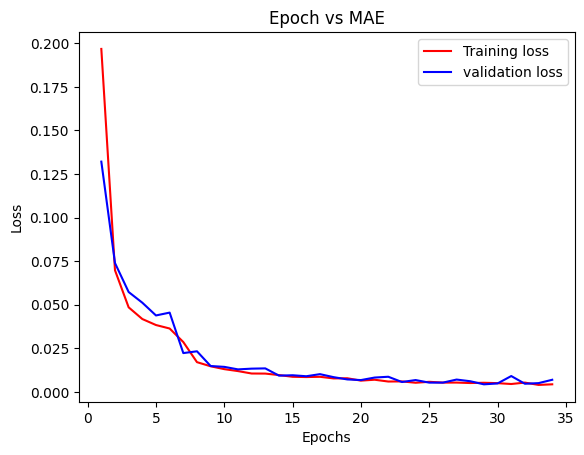

In [23]:
loss_train = history.history['mean_absolute_error']
loss_val = history.history['val_mean_absolute_error']
epochs = range(1,35)
plt.plot(epochs, loss_train, 'r', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Epoch vs MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('MAEPlot.png',dpi=1000)
plt.show()

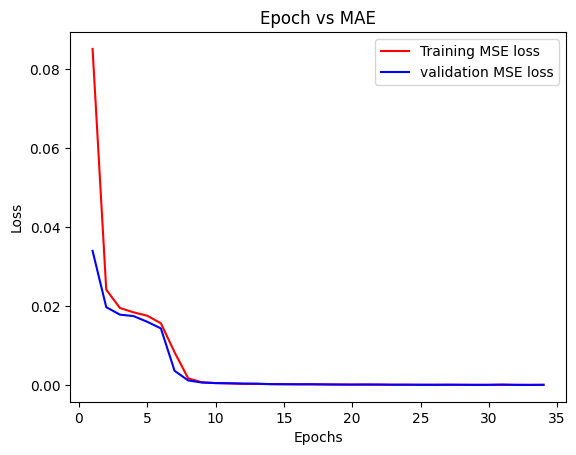

In [24]:
loss_train = history.history['mean_squared_error']
loss_val = history.history['val_mean_squared_error']
epochs = range(1,35)
plt.plot(epochs, loss_train, 'r', label='Training MSE loss')
plt.plot(epochs, loss_val, 'b', label='validation MSE loss')
plt.title('Epoch vs MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('MSEPlot.png',dpi=1000)
plt.show()

In [25]:
from skimage.metrics import structural_similarity as compare_ssim

In [26]:
def calc_ssim22(GT_img, recon_img):
    return compare_ssim(GT_img, recon_img)

In [31]:
SSIM_VALUES_UNET=[]
SSIM_VALUES_BP_RECON=[]
print("SL no","                 RECON          ","          UNET      ")
for i in range (len(y_test_s1)):
    bb=calc_ssim22(y_test_s1[i],x_test_s1[i])
    cc=calc_ssim22(y_test_s1[i],preds_test_s1[i])
    SSIM_VALUES_UNET.append(cc)
    SSIM_VALUES_BP_RECON.append(bb)
    print(i+1,"               " ,bb,"       " ,cc)
print("------------------------------------------------------------------")    
print("Mean SSIM value: ",np.mean(SSIM_VALUES_BP_RECON),"       ",np.mean(SSIM_VALUES_UNET))

SL no                  RECON                     UNET      
1                 0.4273265011980056         0.8510990841162205
2                 0.39243801041412923         0.9661528431085017
3                 0.44278496640223314         0.8507916025071778
4                 0.5898016818862636         0.9644090753384479
5                 0.38062216425224366         0.8465376380380313
6                 0.7383019869381665         0.9658305634071167
7                 0.36783884573055525         0.839815455649573
8                 0.5225732762059473         0.9595125608902567
9                 0.48165046364888253         0.8505328976588798
10                 0.6363804470932544         0.9657445268684166
11                 0.5314393546863979         0.851597703036722
12                 0.6269824058291129         0.9647958778656255
13                 0.46380906822460977         0.8517147550964845
14                 0.7395045612177357         0.9644686928000484
15                 0.43321596222344

In [32]:
model.save("my_model.h5")